In [548]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image, ImageDraw
from IPython.display import display
from numpy.random import rand

In [550]:
#parameters
L1=10   #width
L2=10       #hight
k=1      #ثابت بولتزمن
steps=200 # Number of MC sweeps 
Temp =np.arange(0,10,0.02)  #Temperature range
u=1  #magnetic moment of each spin

#ثابت های تعامل اسپین
J1=1
J2=0.5
J3=0.3

In [552]:
#################       میانگین گیری  انسامبلی      ########################

In [554]:
#functions
def initialstate(L1,L2):        #generating random spins for initial condition
    return np.random.choice([1, -1], size=(L1, L2))    

def calcE(f,J1,J2,J3):      #Calculate Energy
    E = 0
    L1,L2 = f.shape
    for i in range(L1):
        for j in range(L2):
            E += -f[i, j] * dE(f,i,j,J1,J2,J3)
    return E/2   # Divide energy by 2, since we count each site contribution to each of the 2 neighbours 

def dE(f, i, j, J1, J2, J3):
    L1,L2 = f.shape
    ni = 0     #number of intractiojs
    # نزدیکترین همسایگی ها
    ni1 = J1* sum([f[(i - 1) % L1, j],f[(i + 1) % L1, j],f[i, (j - 1) % L2],f[i, (j + 1) % L2]])
    #همسایگی های دوم
    ni2 =J2* sum( [f[(i - 1) % L1, (j - 1) % L2],f[(i - 1) % L1, (j + 1) % L2],f[(i + 1) % L1, (j - 1) % L2],f[(i + 1) % L1, (j + 1) % L2]])
    #همسایگی های سوم
    ni3 = J3* sum([f[(i - 2) % L1, j],f[(i + 2) % L1, j],f[i, (j - 2) % L2],f[i, (j+ 2) % L2]])
    ni= ni1 +ni2 +ni3
    return ni


##########      روش نیوتن    #################
#Calculate <s>
#def S(s,z1,z2,z3,J1,J2,J3,T):   
    #return s - np.tanh((z1*J1 +z2*J2+z3*J3)*s /(k * T))
#def dS(s,z1,z2,z3,J1,J2,J3,T):
   # return 1-(z1*J1 +z2*J2+z3*J3)*(1/np.cosh((z1*J1+z2*J2+z3*J3)*s-(k*T)))**2
#def newtons_method(z1,z2,z3,J1,J2,J3,T,tolerance=1e-6, max_iterations=100):
    #s0 =1
    #for iteration in range(max_iterations):
       # if T > 0:
           # f_s0 = S(s0,z1,z2,z3,J1,J2,J3,T)
           # df_s0=dS(s0,z1,z2,z3,J1,J2,J3,T)
           # if df_s0 == 0:  # جلوگیری از تقسیم بر صفر
           #     return None
          #  s1 = s0 - f_s0 / df_s0   # محاسبه تخمین جدید
          #  if abs(s1 - s0) < tolerance:   #بررسی همگرایی
           #     return s1
          #  s0 = s1  # بهروزرسانی s0 برای تکرار بعدی
       # return None
#calculate Heff
#def H(z1,z2,z3,J1,J2,J3,T):
   # s0= newtons_method (z1, z2, z3, J1, J2, J3, T)
    #return (z1*J1 +z2*J2+z3*J3)*s0/u
##########      روش نیوتن    #################




def calcMag(f):    #Calculate the magnetization
    return np.sum(f) / f.size   # to compensate for over-counting

def calcM_avg(z1,z2,z3,J1,J2,J3,T):    # Calculate average magnetization
    s_avg = relaxation(z1, z2, z3, J1, J2, J3, T)
    ss= (z1*J1 +z2*J2+z2*J3)* (s_avg) 
    return ss   

def relaxation(z1,z2,z3,J1,J2,J3,T, max=100, t=1e-6):      #Relaxation method to calculate average spin
    s_avg = 0.0
    for _ in range(max):
        if T > 0:
            s_avg_new = np.tanh((z1*J1*s_avg + z2*J2*s_avg + z3*J3*s_avg)/(k*T))
        else:
            s_avg_new = 1.0 if (z1*J1 + z2*J2 +z3*J3) > 0 else -1.0
        if abs(s_avg_new - s_avg) < t:
                return s_avg_new
        s_avg= s_avg_new
               
def MC (f,steps,T, J1, J2, J3):      #Perform Monte-Carlo sweeps
    L1, L2 = f.shape
    z1, z2, z3 = 4, 4, 4   #corresponding to the number of nearest neighbors in a square lattice
    M_avg = calcM_avg(z1,z2,z3,J1,J2,J3,T)
    for _ in range(steps):
        i = random.randrange(L1)  # Choose random row
        j = random.randrange(L2)  # Choose random column
        E= dE(f, i, j, J1, J2, J3)
        E_now= -f[i,j]*(E+M_avg)     #spin=f[i,j]
        E_switch= f[i,j] *(E+M_avg) 
        delta_E=E_switch -E_now
        if T==0:
            if delta_E <= 0:  # If the change in energy is negative
                f[i, j] = -f[i, j]  # Accept move and flip spin
        else:
             prob =np.exp(-delta_E /(k*T))
             if np.random.rand()< prob:    # Accept with probability exp(-dU/kT)
                 f[i, j] = -f[i, j]
    return f


def simulate_ising_model (L1,L2,steps,J1,J2,J3,Temp):
    mag=[]
    E_avg=[]
    for T in Temp:
        field = initialstate(L1, L2)
        final_field = field.copy()
        temp_mag = []
        temp_E = []
        for step in range(steps):
            final_field = MC(final_field,steps, T, J1, J2, J3)
            temp_mag.append(calcMag(final_field))
            temp_E.append(calcE(final_field, J1, J2, J3))
        avg_mag = np.mean(np.abs(temp_mag))
        mag.append(avg_mag)
        avg_E = np.mean(temp_E)
        E_avg.append(avg_E) 
    return  E_avg,mag


def simulate_ising_model2 (L1,L2,steps,J1,J2,J3,Temp):
    mag=[]
    E_avg=[]
    for T in Temp:
        field = initialstate(L1, L2)
        final_field = field.copy()
        temp_mag = []
        temp_E = []
        for step in range(steps):
            final_field = MC(final_field,steps, T, J1, J2, J3)
            final_field2 = MC(final_field,steps-1, T, J1, J2, J3)
            temp_mag.append(calcMag(final_field2))
            temp_E.append(calcE(final_field, J1, J2, J3))
        avg_mag = np.mean(np.abs(temp_mag))
        mag.append(avg_mag)
        avg_E = np.mean(temp_E)
        E_avg.append(avg_E) 
    return  E_avg,mag


def plot_results(En_avg, mag,L1,L2,steps,Temp,J1,J2,J3):      #Plot the simulation results
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    axes[0].plot(Temp, En_avg, marker='.', color='IndianRed')
    axes[0].set_xlabel("Temperature (T)", fontsize=16)
    axes[0].set_ylabel("Energy", fontsize=16)
    axes[0].set_title("Average Energy vs Temperature", fontsize=18)
    
    axes[1].plot(Temp, mag, marker='.', color='RoyalBlue')
    axes[1].set_xlabel("Temperature (T)", fontsize=16)
    axes[1].set_ylabel("Magnetization", fontsize=16)
    axes[1].set_title("Magnetization vs Temperature", fontsize=18)

    
    plt.suptitle(f"Simulation of 2D Ising Model\n"
                 f"Lattice Dimension: {L1}x{L2}, Metropolis Step={steps}",
                 fontsize=20)
    plt.tight_layout()
    plt.show()

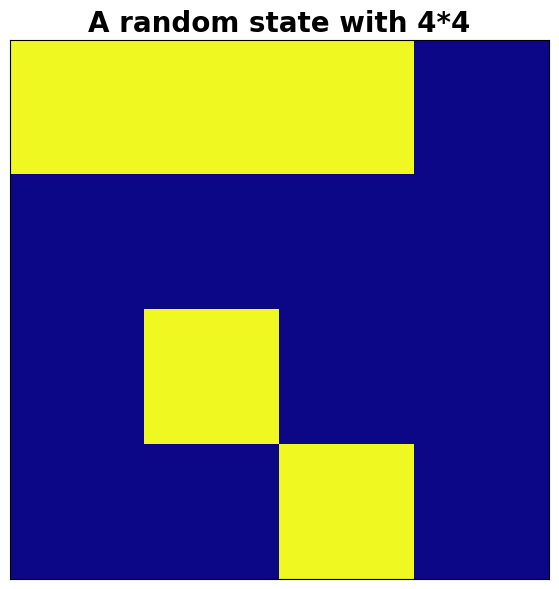

In [541]:
#random initial state
state = initialstate(L1,L2)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title(f"A random state with {L1}*{L2}", fontsize = 20, fontweight = "bold" )
plt.savefig("images.png")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6600\1773960485.py:88: RuntimeWarning: overflow encountered in exp
  prob =np.exp(-delta_E /(k*T))


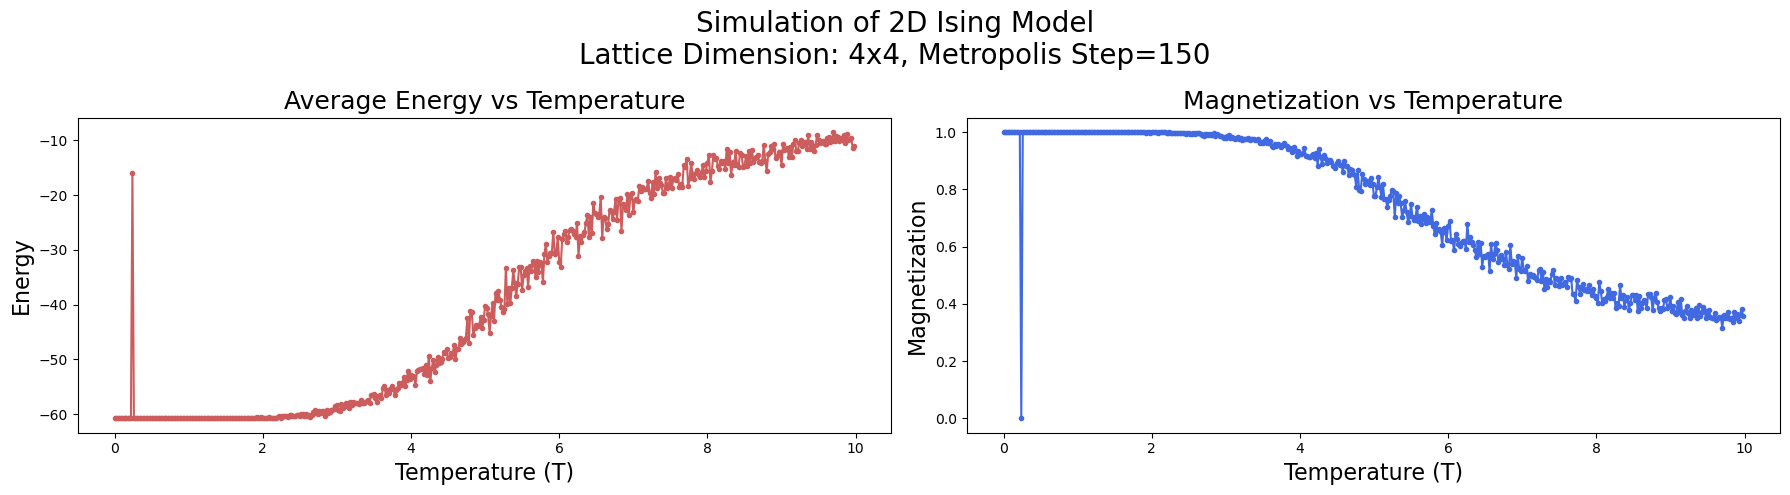

In [426]:
# Run the simulation and plot the results
#miangingiri ansambli
En_avg, mag = simulate_ising_model(L1,L2,steps,J1,J2,J3,Temp)
plot_results(En_avg, mag, L1,L2, steps,Temp,J1,J2,J3)

In [509]:
# Run the simulation and plot the results
#miangingiri zamani
En_avg, mag = simulate_ising_model2(L1,L2,steps,J1,J2,J3,Temp)
plot_results(En_avg, mag, L1,L2, steps,Temp,J1,J2,J3)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6600\481650684.py:88: RuntimeWarning: overflow encountered in exp
  prob =np.exp(-delta_E /(k*T))


KeyboardInterrupt: 

In [543]:
## change these parameters for a smaller (faster) simulation 
#nt      = 88         #  number of temperature points
E,M= np.zeros(nt), np.zeros(nt)
steps=100
N=80
n1, n2  = 1.0/(steps*L1*L2), 1.0/(steps*steps*L1*L2) 
# divide by number of samples, and by system size to get intensive values

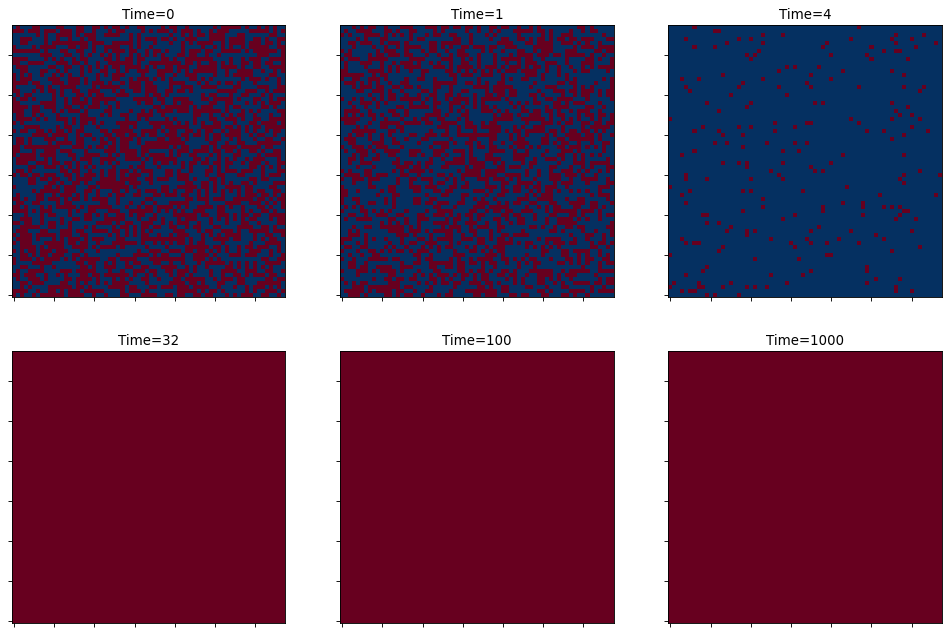

In [557]:
%matplotlib inline
# Simulating the Ising model
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

class Ising():
    def mcmove(self, config, N, beta): ##monte carlo moves
        for i in range(N): 
            for j in range(N):            
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    s =  config[a, b]
                    nb = dE(config, i, j, J1, J2, J3)
                    cost = 2*s*nb
                    if cost < 0:	
                        s *= -1
                    elif rand() < np.exp(-cost*beta):
                        s *= -1
                    config[a, b] = s
        return config
    
    def simulate(self):   
        N, temp     = 68, .4       # Initialse the lattice
        config = 2*np.random.randint(2, size=(N,N))-1
        f = plt.figure(figsize=(15, 15), dpi=80);    
        self.configPlot(f, config, 0, N, 1);
        msrmnt = 1001
        for i in range(msrmnt):
            self.mcmove(config, N, 1.0/temp)
            if i == 1:       self.configPlot(f, config, i, N, 2);
            if i == 4:       self.configPlot(f, config, i, N, 3);
            if i == 32:      self.configPlot(f, config, i, N, 4);
            if i == 100:     self.configPlot(f, config, i, N, 5);
            if i == 1000:    self.configPlot(f, config, i, N, 6);
                             
    def configPlot(self, f, config, i, N, n_):
        X, Y = np.meshgrid(range(N), range(N))
        sp =  f.add_subplot(3, 3, n_ )  
        plt.setp(sp.get_yticklabels(), visible=False)
        plt.setp(sp.get_xticklabels(), visible=False)      
        plt.pcolormesh(X, Y, config, cmap=plt.cm.RdBu);
        plt.title('Time=%d'%i); plt.axis('tight')    
    plt.show()
    
rm = Ising()
rm.simulate()
